In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize
from pathlib import Path

In [4]:
stocks = ["AAPL", "MSFT", "AMZN", "JPM", "JNJ", "XOM", "PFE", "TSLA", "META", "KO"]
assets_path = Path("../data/assets")
factors_path = Path("../data/factors")

In [6]:
stock_returns = pd.read_csv(assets_path / "asset_returns.csv", index_col=0, parse_dates=True)
factors = pd.read_csv(factors_path / "ff3_daily_clean.csv", index_col=0, parse_dates=True)
# Prepare excess returns
excess_returns = stock_returns.sub(factors['RF'], axis=0)

In [7]:
results_capm = {}
results_ff3 = {}

for stock in stocks:
    y = excess_returns[stock].dropna()
    X_capm = sm.add_constant(factors['Mkt-RF'].loc[y.index])
    X_ff3 = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']].loc[y.index])
    
    model_capm = sm.OLS(y, X_capm).fit()
    model_ff3 = sm.OLS(y, X_ff3).fit()
    
    results_capm[stock] = model_capm
    results_ff3[stock] = model_ff3

In [111]:
window = 126  # 6 months

params = {prod: list() for prod in stock_returns.columns}
errors = {prod: list() for prod in stock_returns.columns}

def fit(x, X, prod):
    model = sm.OLS(x, X.loc[x.index]).fit()
    params[prod].append(model.params)
    errors[prod].append(model.mse_resid)
    return 0

rolling_betas = {}
for stock in stocks:
    y = excess_returns[stock].dropna()
    X = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']].loc[y.index])
    rolling = y.rolling(window).apply(lambda x: fit(x, X, stock))
    rolling_betas[stock] = rolling

In [106]:
params[0]

const     0.000103
Mkt-RF    1.007780
SMB      -0.104433
HML      -0.712631
dtype: float64

In [112]:
for stock in stocks:
    params[stock] = pd.DataFrame(np.array(params[stock]))
    params[stock].columns = ['const', 'Mkt-RF', 'SMB', 'HML']

In [113]:
params['AAPL']

,const,Mkt-RF,SMB,HML
0,0.000103,1.007780,-0.104433,-0.712631
1,0.000151,1.006889,-0.121775,-0.715368
2,0.000155,1.008080,-0.120444,-0.720120
3,0.000242,1.015443,-0.121619,-0.674087
4,0.000236,1.017337,-0.107493,-0.664498
...,...,...,...,...
1629,0.000979,0.815026,-0.222572,-0.333361
1630,0.000851,0.816493,-0.225145,-0.329204
1631,0.000864,0.814551,-0.221399,-0.330153
1632,0.000897,0.814424,-0.212208,-0.321609


In [114]:
errors['AAPL']

[0.00011056511770049144,
 0.00011013674157802112,
 0.00011017399696520773,
 0.00011090430824997285,
 0.00011088942394835175,
 0.00011155135782846207,
 0.0001114181842568889,
 0.00011143596938381975,
 0.00011148257789629264,
 0.00011184489056632305,
 0.00011171024116335762,
 0.00011248363609555327,
 0.00011165379514255988,
 0.00010916542901840755,
 0.00010927738011549555,
 0.00010817039209923728,
 0.0001041339148619437,
 0.00010266547261887694,
 0.00010121170370938654,
 0.00010191391675000509,
 0.00012940993445741114,
 0.00013168135864015878,
 0.00012619251279958623,
 0.00012536371025862532,
 0.0001233155400028138,
 0.00012099047073169643,
 0.00012000996122255008,
 0.00011994953071617659,
 0.00011619303320073347,
 0.00011607842640375544,
 0.00011631700919010624,
 0.00011447800696560382,
 0.00011651256217466477,
 0.00011776152916259631,
 0.00011788947598437375,
 0.00011781032192449184,
 0.00011781179218386655,
 0.00011788587588761457,
 0.00011746523359670402,
 0.00011744138967982579,
 0.

In [115]:
tickers = stock_returns.columns
n_assets = len(tickers)
weights = np.ones(n_assets) / n_assets

In [ ]:
factor_cov = factors[["Mkt-RF", "SMB", "HML"]].cov()

In [ ]:
portfolio_betas = list()

In [ ]:
#.shape

,0,1,2
0,1.007780,-0.104433,-0.712631
1,1.075670,-0.317299,-1.440440
2,0.877177,-0.335590,0.261776
3,1.166193,-0.386049,1.119852
4,0.548103,-0.248816,-0.126173
5,1.227159,0.162349,-0.969816
6,1.344284,-0.461728,-0.707582
7,0.815332,-0.257304,0.224210
8,1.495577,0.465607,-0.734050
9,0.929112,0.051480,0.796806


In [138]:
np.array([errors[prod] for prod in tickers]).T.shape

(1634, 10)

In [140]:
np.concatenate([params[prod].to_numpy()[:,:,np.newaxis] for prod in tickers], axis=2)[:,1:,:].T.shape

(10, 3, 1634)

In [ ]:
roll_betas_param = np.concatenate([params[prod].to_numpy()[:,:,np.newaxis] for prod in tickers], axis=2)[0,1:,:].T
roll_error_param = np.array([errors[prod] for prod in tickers]).T

ValueError: Must pass 2-d input. shape=(10, 3, 1634)

In [141]:
np.array([errors[prod] for prod in tickers]).T.shape

(1634, 10)

In [142]:
from tqdm import tqdm

In [144]:
portfolio_betas = list()
portfolio_var_factors = list()
portfolio_var_idiosyncratics = list()
for i in tqdm(range(params['AAPL'].shape[0])):
    beta_ff3 = pd.DataFrame(np.concatenate([params[prod].to_numpy()[:,:,np.newaxis] for prod in tickers], axis=2)[i,1:,:].T)
    residual_var = np.array([errors[prod] for prod in tickers]).T[i]
    portfolio_beta = np.dot(weights, beta_ff3)
    portfolio_var_factor = np.dot(portfolio_beta, np.dot(factor_cov, portfolio_beta.T))
    portfolio_var_idiosyncratic = np.dot(weights**2, residual_var)
    portfolio_var_total = portfolio_var_factor + portfolio_var_idiosyncratic
    portfolio_betas.append(portfolio_beta)
    portfolio_var_factors.append(portfolio_var_factor)
    portfolio_var_idiosyncratics.append(portfolio_var_idiosyncratic)

100%|██████████| 1634/1634 [00:00<00:00, 1740.48it/s]


In [147]:
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [146]:
portfolio_betas[0]

array([ 1.04863856, -0.14317823, -0.22880471])

In [150]:
portfolio_betas = np.array(portfolio_betas)

In [151]:
portfolio_betas.shape

(1634, 3)

In [155]:
time = rolling[~np.isnan(rolling)].index

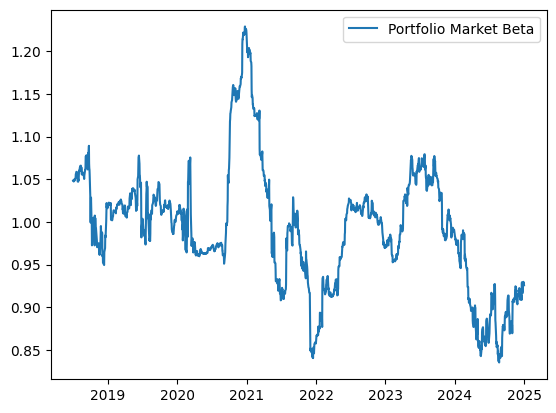

In [ ]:
plt.plot(time, portfolio_betas[:,0], label = f'Portfolio Market Beta')
plt.plot(time, portfolio_var_factors, label = f'Factor Risk')
plt.plot(time, portfolio_var_idiosyncratics, label = f'Idiosyncratic Risk')
plt.legend()

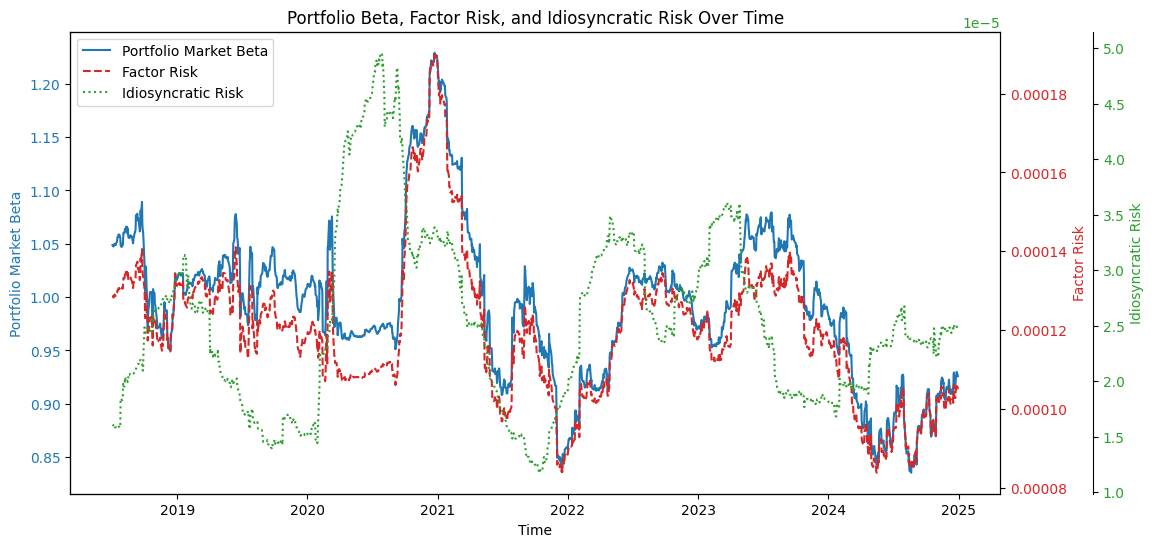

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Axis 1 - Portfolio Market Beta
color1 = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio Market Beta', color=color1)
ax1.plot(time, portfolio_betas[:,0], color=color1, label='Portfolio Market Beta')
ax1.tick_params(axis='y', labelcolor=color1)

# Axis 2 - Factor Risk
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Factor Risk', color=color2)
ax2.plot(time, portfolio_var_factors, color=color2, linestyle='--', label='Factor Risk')
ax2.tick_params(axis='y', labelcolor=color2)

# Axis 3 - Idiosyncratic Risk (shifted right)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))  # move the third y-axis a bit right
color3 = 'tab:green'
ax3.set_ylabel('Idiosyncratic Risk', color=color3)
ax3.plot(time, portfolio_var_idiosyncratics, color=color3, linestyle=':', label='Idiosyncratic Risk')
ax3.tick_params(axis='y', labelcolor=color3)

# Combine legends from all axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

plt.title('Portfolio Beta, Factor Risk, and Idiosyncratic Risk Over Time')
plt.show()


In [157]:
portfolio_var_factors[0]

0.00012846828833802969

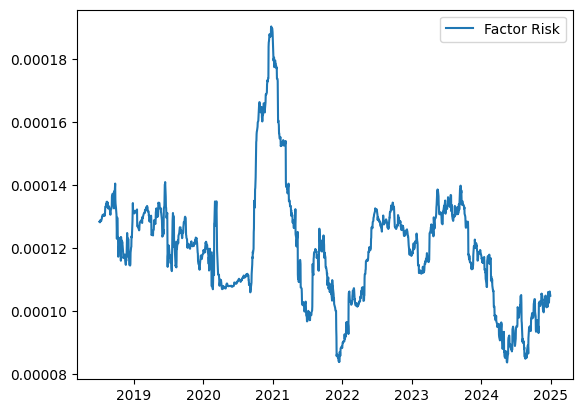

In [162]:
plt.plot(time, portfolio_var_factors, label = f'Factor Risk')
# plt.plot(time, portfolio_var_idiosyncratics, label = f'Idiosyncratic Risk')
plt.legend()
# plt.legend()

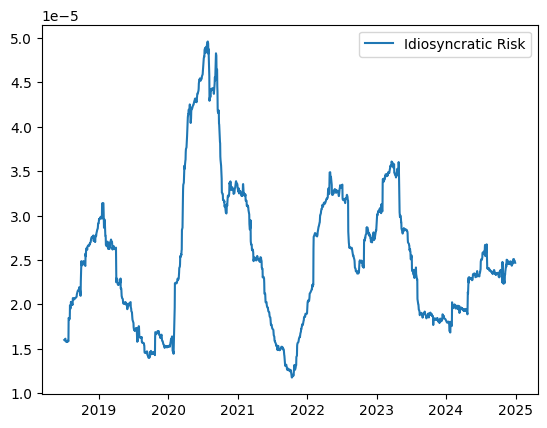

In [160]:
plt.plot(time, portfolio_var_idiosyncratics, label = f'Idiosyncratic Risk')
plt.legend()

In [86]:
window = 126  # 6 months

rolling_betas = {}
for stock in stocks:
    y = excess_returns[stock].dropna()
    X = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']].loc[y.index])
    rolling = y.rolling(window).apply(lambda x: sm.OLS(x, X.loc[x.index]).fit().params[1], raw=False)
    rolling_betas[stock] = rolling

In [87]:
window = 126  # 6 months

rolling_betas1 = {}
for stock in stocks:
    y = excess_returns[stock].dropna()
    X = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']].loc[y.index])
    rolling = y.rolling(window).apply(lambda x: sm.OLS(x, X.loc[x.index]).fit().params[2], raw=False)
    rolling_betas1[stock] = rolling

In [88]:
window = 126  # 6 months

rolling_betas2 = {}
for stock in stocks:
    y = excess_returns[stock].dropna()
    X = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']].loc[y.index])
    rolling = y.rolling(window).apply(lambda x: sm.OLS(x, X.loc[x.index]).fit().params[3], raw=False)
    rolling_betas2[stock] = rolling

In [73]:
tickers = stock_returns.columns
n_assets = len(tickers)
weights = np.ones(n_assets) / n_assets

In [ ]:
beta

In [81]:
factor_cov = factors[["Mkt-RF", "SMB", "HML"]].cov()

In [ ]:
for prod in stock_returns.columns:
    portfolio_beta = np.dot(weights, beta_ff3)
    portfolio_var_factor = np.dot(portfolio_beta, np.dot(factor_cov, portfolio_beta.T))
    portfolio_var_idiosyncratic = np.dot(weights**2, residual_var)
    portfolio_var_total = portfolio_var_factor + portfolio_var_idiosyncratic

AAPL   NaN
AAPL   NaN
AAPL   NaN
Name: 2018-01-03 00:00:00, dtype: float64


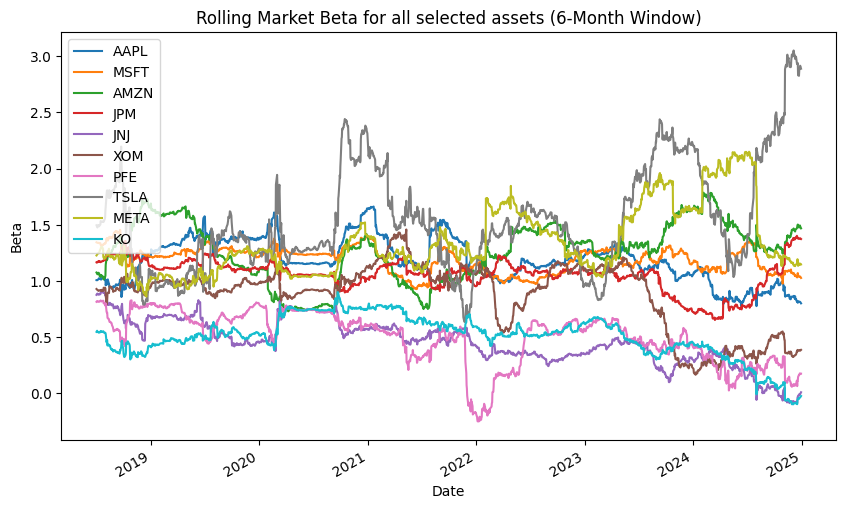

In [32]:
plt.figure(figsize=(10,6))
for prod in rolling_betas:
    rolling_betas[prod].plot(label = prod)
plt.legend()
plt.title('Rolling Market Beta for all selected assets (6-Month Window)')
plt.ylabel('Beta')
plt.show()

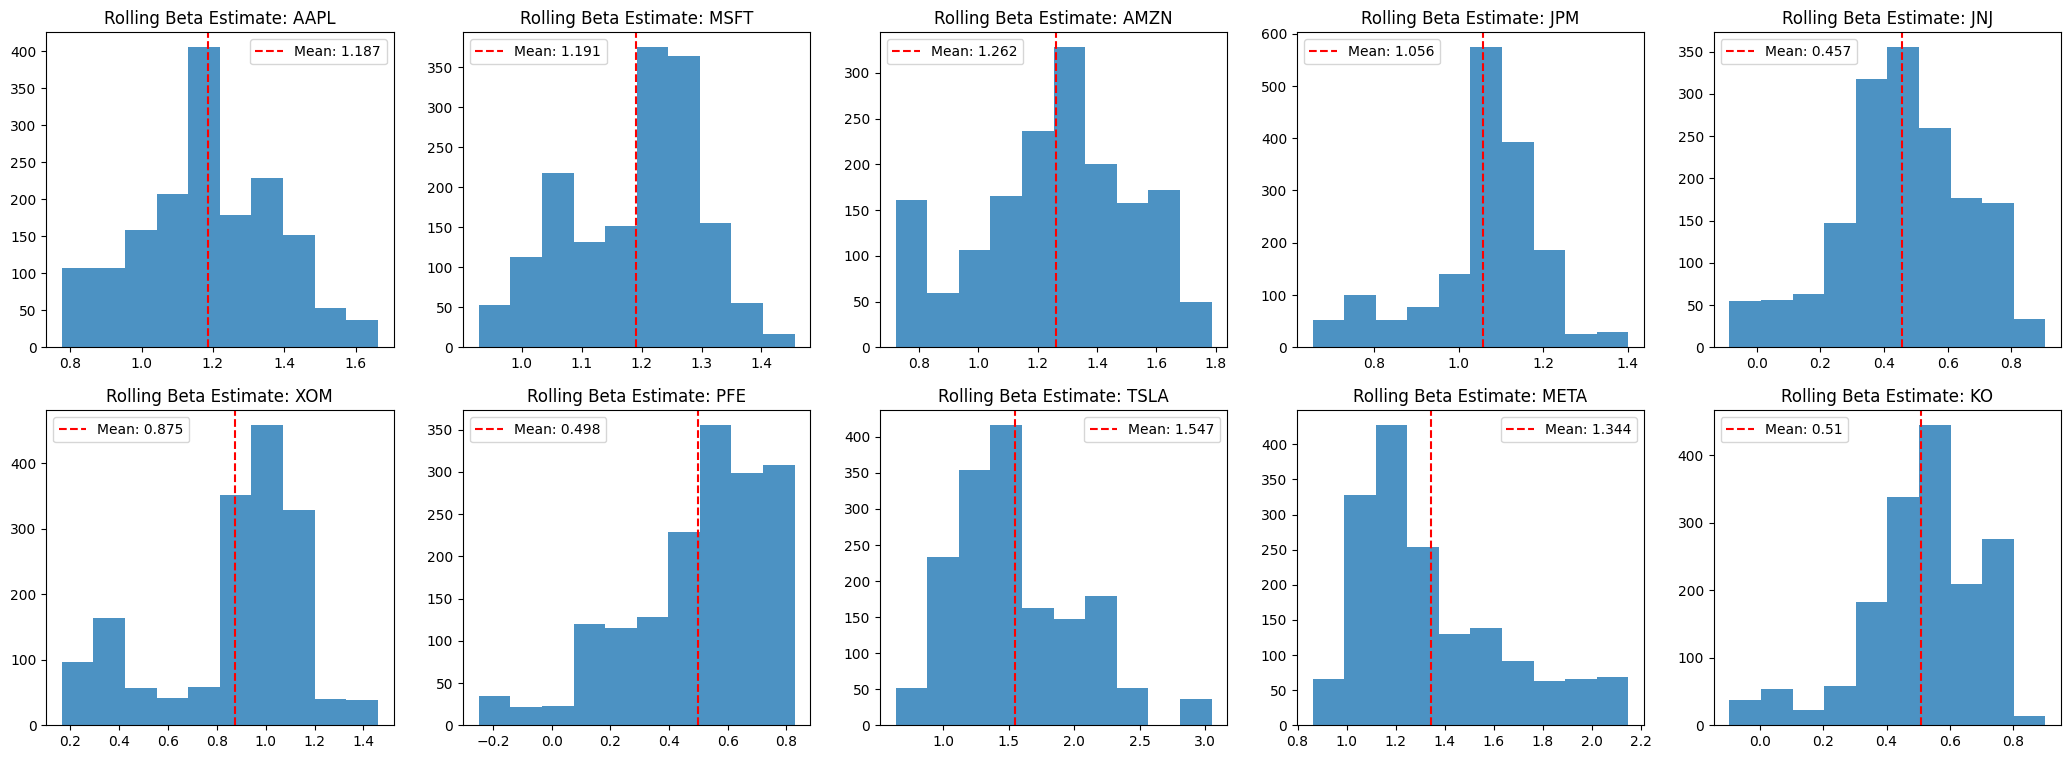

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(26,9))
for i, prod in enumerate(rolling_betas):
    axes[i//5, i%5].hist(rolling_betas[prod], alpha=0.8)
    axes[i//5, i%5].set_title(f'Rolling Beta Estimate: {prod}')
    axes[i//5, i%5].axvline(rolling_betas[prod].mean(), color='red', linestyle='--', label = f'Mean: {round(rolling_betas[prod].mean(), 3)}')
    axes[i//5, i%5].legend()
plt.show()

In [9]:
alpha_test_results = []

for stock, model in results_ff3.items():
    alpha = model.params['const']
    alpha_se = model.bse['const']
    t_stat = alpha / alpha_se
    p_value = stats.t.sf(np.abs(t_stat), df=model.df_resid) * 2
    
    alpha_test_results.append({
        'Stock': stock,
        'Alpha': alpha,
        't-Stat': t_stat,
        'p-Value': p_value
    })

alpha_test_df = pd.DataFrame(alpha_test_results)
print("\nAlpha Significance Testing (FF3):")
print(alpha_test_df)


Alpha Significance Testing (FF3):
  Stock     Alpha    t-Stat   p-Value
0  AAPL  0.000491  1.804719  0.071290
1  MSFT  0.000356  1.696565  0.089956
2  AMZN  0.000249  0.733887  0.463116
3   JPM  0.000207  0.915073  0.360279
4   JNJ -0.000161 -0.655853  0.512005
5   XOM  0.000103  0.319629  0.749288
6   PFE -0.000250 -0.735147  0.462348
7  TSLA  0.001658  2.065275  0.039044
8  META  0.000235  0.499282  0.617643
9    KO -0.000006 -0.027708  0.977898


In [17]:
expected_returns

AAPL    1.166061
MSFT    1.167358
AMZN    1.142014
JPM     1.035446
JNJ     0.473484
XOM     0.814368
PFE     0.537224
TSLA    1.586761
META    1.276622
KO      0.546297
dtype: float64

In [20]:
cov_matrix

,AAPL,MSFT,AMZN,JPM,JNJ,XOM,PFE,TSLA,META,KO
AAPL,0.000370,0.000256,0.000250,0.000152,0.000084,0.000114,0.000093,0.000346,0.000275,0.000092
MSFT,0.000256,0.000331,0.000274,0.000150,0.000085,0.000097,0.000099,0.000312,0.000291,0.000092
AMZN,0.000250,0.000274,0.000470,0.000122,0.000055,0.000072,0.000071,0.000357,0.000346,0.000056
JPM,0.000152,0.000150,0.000122,0.000348,0.000091,0.000205,0.000104,0.000202,0.000153,0.000111
JNJ,0.000084,0.000085,0.000055,0.000091,0.000152,0.000074,0.000104,0.000047,0.000064,0.000082
XOM,0.000114,0.000097,0.000072,0.000205,0.000074,0.000381,0.000083,0.000126,0.000094,0.000096
PFE,0.000093,0.000099,0.000071,0.000104,0.000104,0.000083,0.000257,0.000057,0.000083,0.000083
TSLA,0.000346,0.000312,0.000357,0.000202,0.000047,0.000126,0.000057,0.001611,0.000336,0.000076
META,0.000275,0.000291,0.000346,0.000153,0.000064,0.000094,0.000083,0.000336,0.000698,0.000068
KO,0.000092,0.000092,0.000056,0.000111,0.000082,0.000096,0.000083,0.000076,0.000068,0.000152


In [53]:
import seaborn as sns

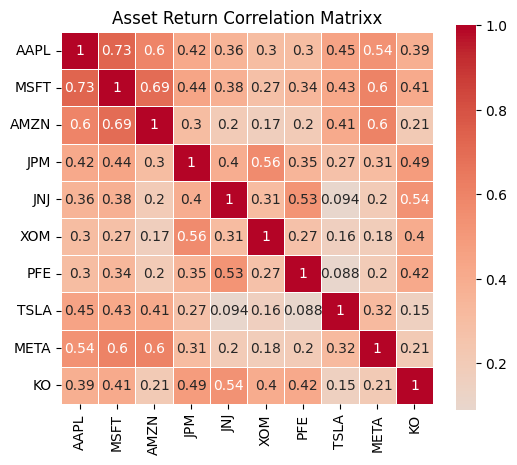

In [55]:
std_dev = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / std_dev[:, None] / std_dev[None, :]

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Asset Return Correlation Matrixx")
plt.show()

In [28]:
# Target expected excess return
target_excess_return = 1  # 0.1% per day

# Estimate expected returns and covariance
expected_returns = pd.Series({s: m.params['Mkt-RF'] for s, m in results_capm.items()})
cov_matrix = excess_returns[stocks].cov()

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

def constraint_target_return(weights):
    return weights @ expected_returns.values - target_excess_return

constraints = ({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
}, {
    'type': 'eq',
    'fun': constraint_target_return
})

bounds = [(0, 1) for _ in stocks]
initial_weights = np.ones(len(stocks)) / len(stocks)

opt_result = minimize(portfolio_volatility, initial_weights,
                      args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

optimal_weights = opt_result.x
print("\nOptimal Portfolio Weights:")
for stock, w in zip(stocks, optimal_weights):
    print(f"{stock}: {w:.4f}")


Optimal Portfolio Weights:
AAPL: 0.1433
MSFT: 0.1645
AMZN: 0.0968
JPM: 0.1929
JNJ: 0.0574
XOM: 0.1215
PFE: 0.0378
TSLA: 0.0395
META: 0.0569
KO: 0.0894


In [29]:
# Assume market drops 5% => stress all assets proportionally to their betas
market_shock = -0.05
portfolio_beta = sum(optimal_weights[i] * results_capm[stocks[i]].params['Mkt-RF'] for i in range(len(stocks)))
expected_portfolio_loss = portfolio_beta * market_shock

print(f"\nExpected Portfolio Loss under 5% Market Shock: {expected_portfolio_loss:.2%}")


Expected Portfolio Loss under 5% Market Shock: -5.00%


In [58]:
import pickle
outputs_path = Path("../outputs")
with open(outputs_path / "model_results.pkl", "rb") as f:
    results = pickle.load(f)

In [59]:
tickers = stock_returns.columns
factor_cov = factors[["Mkt-RF", "SMB", "HML"]].cov()
residual_var = pd.Series({ticker: results[ticker]["FF3"].mse_resid for ticker in tickers})

In [62]:
pd.concat(list(rolling_betas.values()), axis=1)

,AAPL,MSFT,AMZN,JPM,JNJ,XOM,PFE,TSLA,META,KO
Date,,,,,,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.815026,1.039346,1.475939,1.375125,-0.012124,0.384808,0.165278,2.824624,1.148264,-0.048653
2024-12-24,0.816493,1.036919,1.476808,1.375997,-0.006303,0.381280,0.164656,2.874810,1.146649,-0.037650
2024-12-26,0.814551,1.037528,1.494508,1.377042,-0.008476,0.382357,0.178850,2.890636,1.156511,-0.035259


In [ ]:
plt.figure(figsize=(10,6))
for prod in rolling_betas:
    rolling_betas[prod].plot(label = prod)
plt.legend()
plt.title('Rolling Market Beta for all selected assets (6-Month Window)')
plt.ylabel('Beta')
plt.show()

In [ ]:
portfolio_beta = np.dot(weights, beta_ff3)
portfolio_var_factor = np.dot(portfolio_beta, np.dot(factor_cov, portfolio_beta.T))
portfolio_var_idiosyncratic = np.dot(weights**2, residual_var)
portfolio_var_total = portfolio_var_factor + portfolio_var_idiosyncratic